<a href="https://colab.research.google.com/github/dilshanindi/Bank_Marketing/blob/main/ML_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bank Marketing - Term Deposit Prediction**

##### **Machine Learning (CM2604) - Assessment**
##### **Name: Dilshan Indigahawela**
##### **RGU ID: 2330920**
##### **IIT ID: 20230770**


In [90]:
!pip install imbalanced-learn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping


In [91]:
from google.colab import files

uploaded = files.upload()

data = pd.read_csv('bank-additional-full.csv', sep=';')
data.head()


Saving bank-additional-full.csv to bank-additional-full (2).csv


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [92]:
data.shape

(41188, 21)

In [93]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [95]:
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [96]:
data.duplicated().sum()

12

# Replace 'unknown' values with NaN in categorical *columns*

In [97]:
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
data[categorical_cols] = data[categorical_cols].replace('unknown', np.nan)



#  Handle missing values

           Missing Values  Percentage
job                   330    0.801204
marital                80    0.194231
education            1731    4.202680
default              8597   20.872584
housing               990    2.403613
loan                  990    2.403613


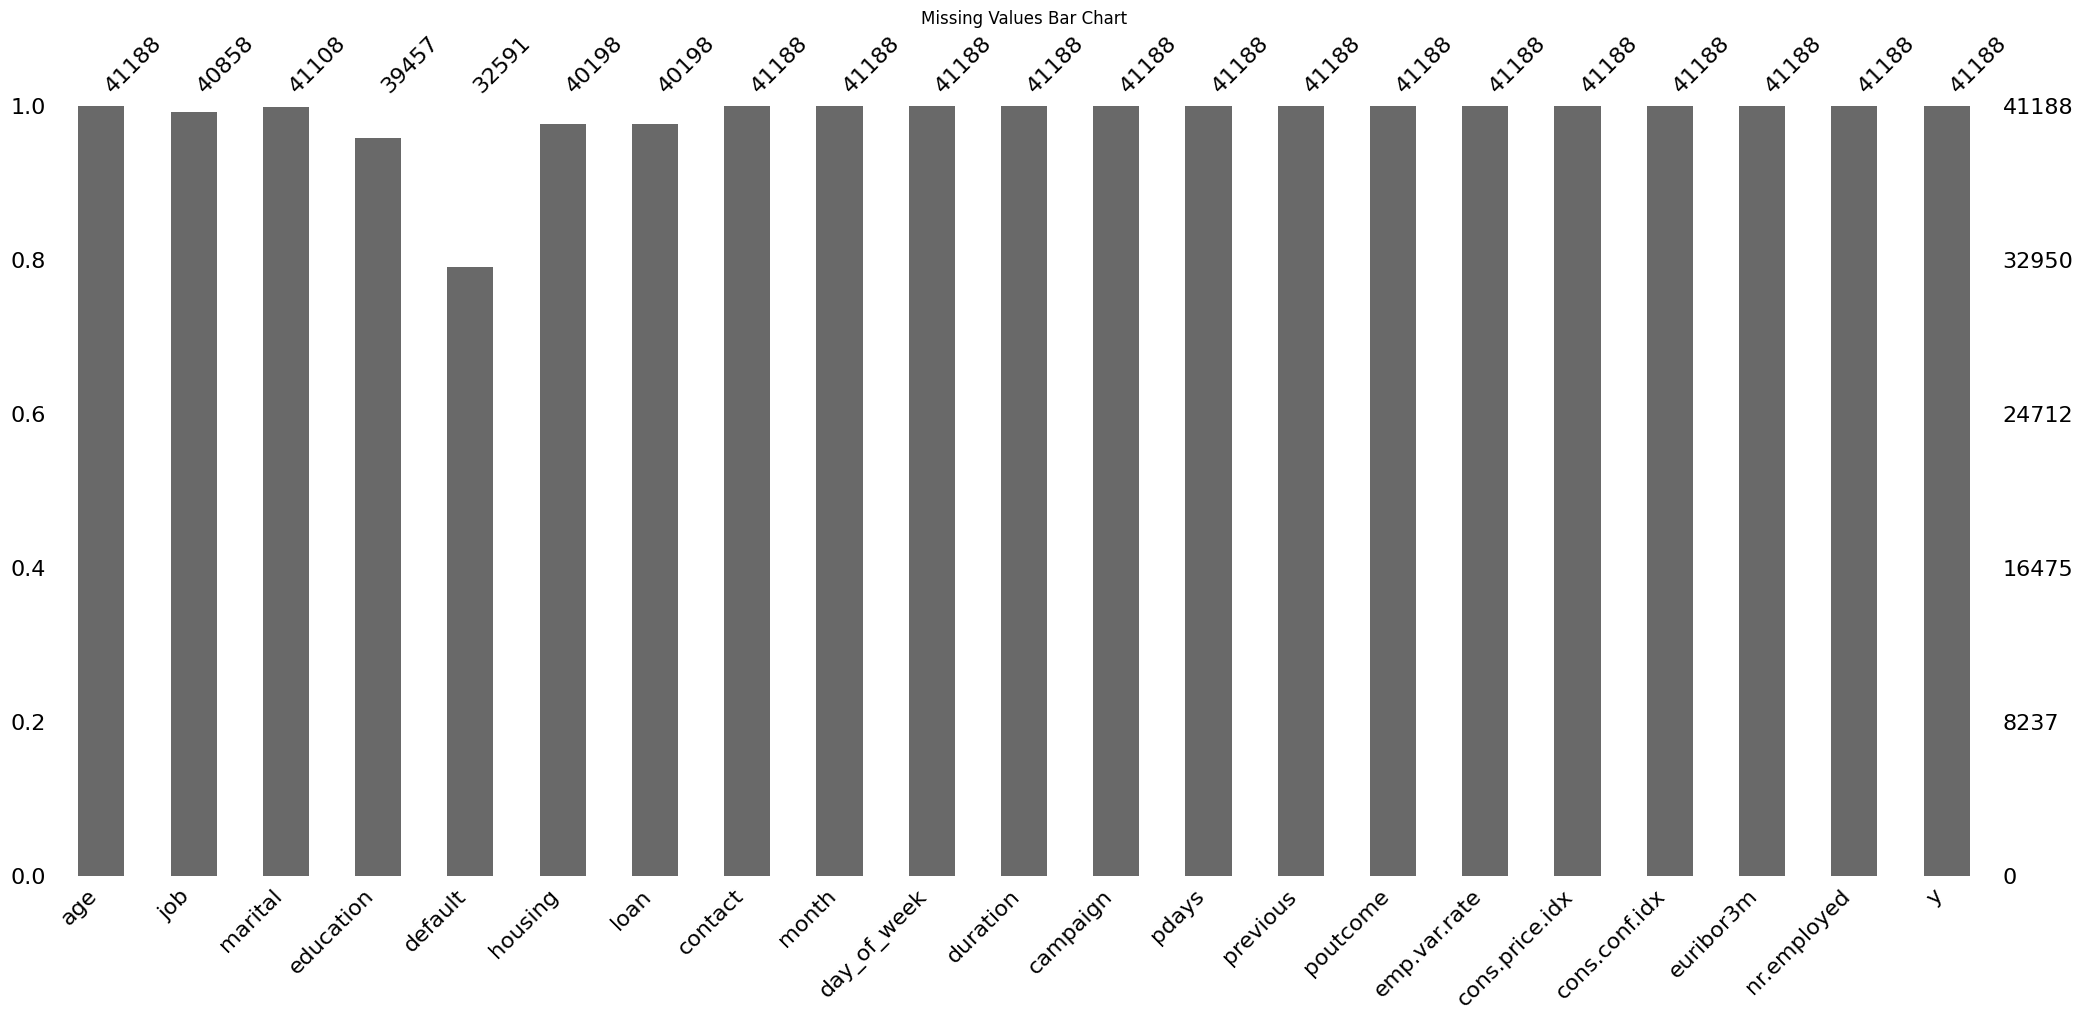

In [98]:
from sklearn.impute import SimpleImputer

categorical_cols = data.select_dtypes(include=['object']).columns
numerical_cols = data.select_dtypes(include=[np.number]).columns

missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100

missing_data = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})
missing_data = missing_data[missing_data['Missing Values'] > 0]
print(missing_data)

import missingno as msno

msno.bar(data)
plt.title("Missing Values Bar Chart")
plt.show()






#  Feature engineering

<ipython-input-99-c41a22f5d170>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='age_group', data=data, palette='viridis')


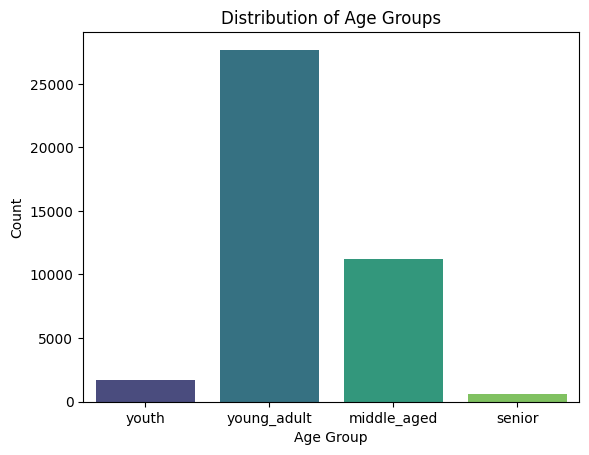

In [99]:

data['age_group'] = pd.cut(
    data['age'],
    bins=[0, 25, 45, 65, 100],
    labels=['youth', 'young_adult', 'middle_aged', 'senior'],
    include_lowest=True
)

sns.countplot(x='age_group', data=data, palette='viridis')
plt.title('Distribution of Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()




<ipython-input-100-cd246fef1b31>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='job', data=data, order=data['job'].value_counts().index, palette='coolwarm')


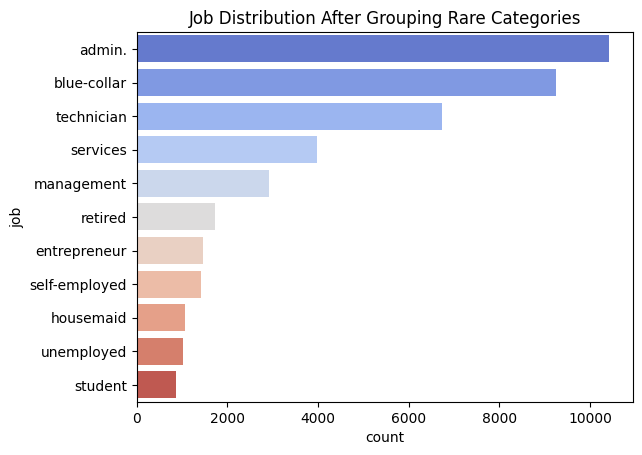

In [100]:
rare_jobs = data['job'].value_counts()[data['job'].value_counts() < 100].index
data['job'] = data['job'].replace(rare_jobs, 'other')

sns.countplot(y='job', data=data, order=data['job'].value_counts().index, palette='coolwarm')
plt.title('Job Distribution After Grouping Rare Categories')
plt.show()


In [101]:
data['education_marital'] = data['education'] + '_' + data['marital']

data['contact_day'] = data['contact'] + '_' + data['day_of_week']

print(data[['education_marital', 'contact_day']].head())


     education_marital    contact_day
0     basic.4y_married  telephone_mon
1  high.school_married  telephone_mon
2  high.school_married  telephone_mon
3     basic.6y_married  telephone_mon
4  high.school_married  telephone_mon


<ipython-input-102-cdf5af8e588a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='month_num', data=data, palette='Set2')


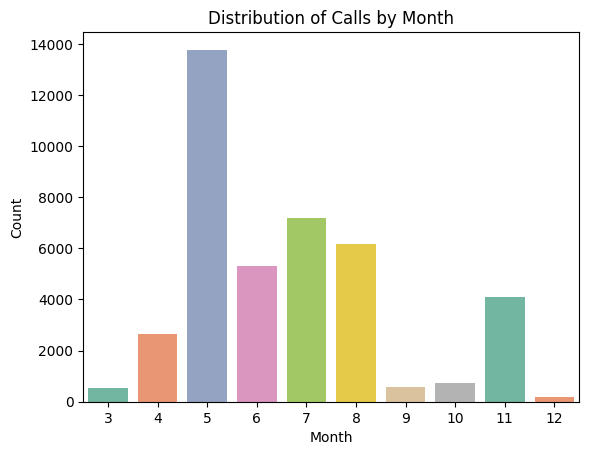

In [102]:
month_map = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
             'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
data['month_num'] = data['month'].map(month_map)

sns.countplot(x='month_num', data=data, palette='Set2')
plt.title('Distribution of Calls by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()


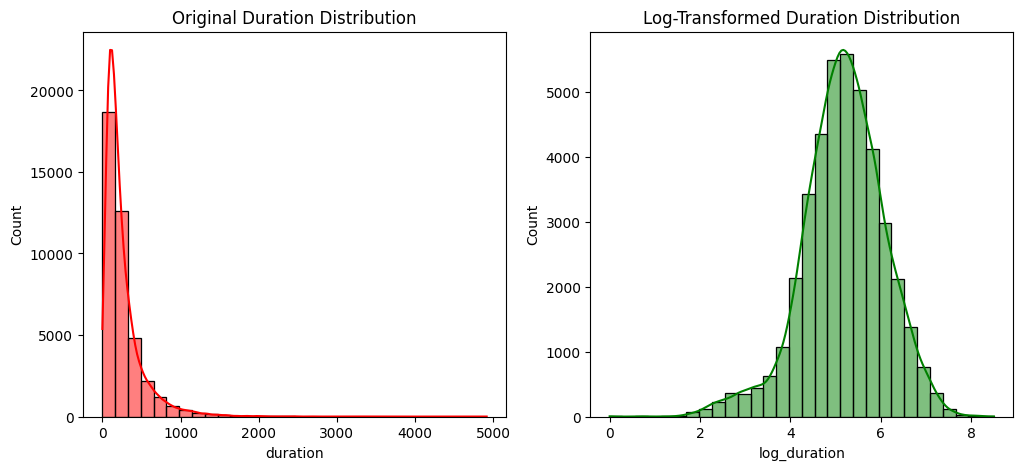

In [103]:
data['log_duration'] = np.log1p(data['duration'])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(data['duration'], bins=30, kde=True, ax=ax[0], color='red')
ax[0].set_title('Original Duration Distribution')
sns.histplot(data['log_duration'], bins=30, kde=True, ax=ax[1], color='green')
ax[1].set_title('Log-Transformed Duration Distribution')
plt.show()


In [104]:
binary_cols = ['default', 'housing', 'loan', 'y']
data[binary_cols] = data[binary_cols].replace({'yes': 1, 'no': 0})

print(data[binary_cols].head())




   default  housing  loan  y
0      0.0      0.0   0.0  0
1      NaN      0.0   0.0  0
2      0.0      1.0   0.0  0
3      0.0      0.0   0.0  0
4      0.0      0.0   1.0  0


<ipython-input-104-bebf6d742812>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[binary_cols] = data[binary_cols].replace({'yes': 1, 'no': 0})


In [105]:
categorical_features = ['job', 'marital', 'education', 'month', 'day_of_week', 'poutcome', 'age_group', 'education_marital', 'contact_day']

data = pd.get_dummies(data, columns=categorical_features, drop_first=True)

print("Missing values in the data:", data.isnull().sum().sum())

print("Non-numeric columns in data:", data.select_dtypes(include=['object']).columns)



Missing values in the data: 10577
Non-numeric columns in data: Index(['contact'], dtype='object')


#  Drop unnecessary columns


In [106]:
data.drop(['duration', 'default', 'contact'], axis=1, inplace=True)


#Scale numerical features


In [107]:
numerical_cols = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
                  'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])



#Separate features and target


In [108]:
X = data.drop(columns=['y'])
y = data['y']



#  Train-test split

In [109]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print("Training Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)

Training Set Shape: (26360, 78)
Testing Set Shape: (8238, 78)


#  Balance the dataset using SMOTE

In [110]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = X_train.replace('nonexistent', np.nan).dropna()
y_train = y_train[X_train.index]

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

from collections import Counter
print("Class distribution after SMOTE (Training):", Counter(y_train_resampled))

print("Target distribution after SMOTE:", np.bincount(y_train_resampled))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Class distribution after SMOTE (Training): Counter({0: 28532, 1: 28532})
Target distribution after SMOTE: [28532 28532]


<ipython-input-111-c9ac9ea320d7>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=class_values, palette="viridis")


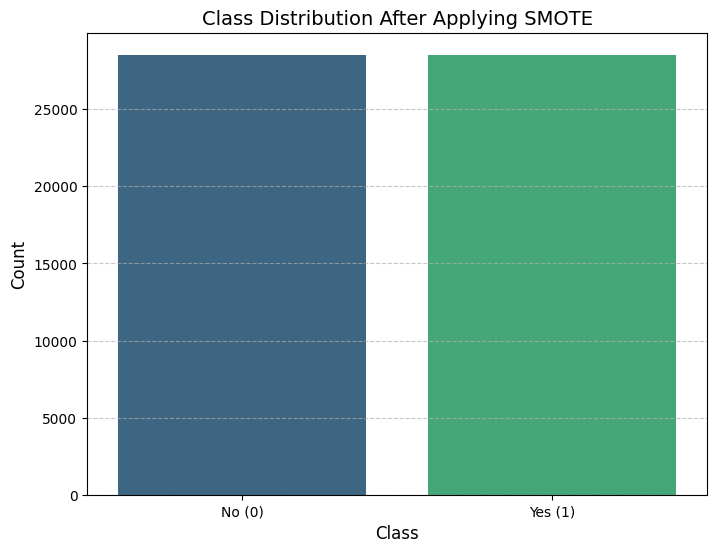

In [111]:
class_counts = Counter(y_train_resampled)

class_labels = list(class_counts.keys())
class_values = list(class_counts.values())

plt.figure(figsize=(8, 6))
sns.barplot(x=class_labels, y=class_values, palette="viridis")
plt.title("Class Distribution After Applying SMOTE", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No (0)', 'Yes (1)'], fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


#Random Forest

In [112]:
print("Duplicate rows in the dataset:", data.duplicated().sum())

train_stats = X_train.describe()
test_stats = X_test.describe()
print("Feature Distribution in Training Set:\n", train_stats)
print("Feature Distribution in Test Set:\n", test_stats)


Duplicate rows in the dataset: 14
Feature Distribution in Training Set:
                 age       housing          loan      campaign         pdays  \
count  32154.000000  32154.000000  32154.000000  32154.000000  32154.000000   
mean      -0.001237      0.536605      0.156217     -0.002250     -0.003027   
std        0.998381      0.498666      0.363067      0.991489      1.007446   
min       -2.209365      0.000000      0.000000     -0.565922     -5.149443   
25%       -0.769980      0.000000      0.000000     -0.565922      0.195414   
50%       -0.194227      1.000000      0.000000     -0.204909      0.195414   
75%        0.669404      1.000000      0.000000      0.156105      0.195414   
max        5.563310      1.000000      1.000000     14.596643      0.195414   

           previous  emp.var.rate  cons.price.idx  cons.conf.idx  \
count  32154.000000  32154.000000    32154.000000   32154.000000   
mean       0.003239     -0.001842       -0.002847      -0.002101   
std        

In [113]:
data = data.drop_duplicates()
print("Dataset after removing duplicates:", data.shape)


Dataset after removing duplicates: (41174, 79)


Cross-Validation F1 Scores: [0.58337161 0.60056657 0.56261023 0.5785877  0.58504591]
Mean F1 Score: 0.5820364049633374
Training Performance:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91     28532
           1       0.44      0.95      0.60      3622

    accuracy                           0.86     32154
   macro avg       0.72      0.90      0.76     32154
weighted avg       0.93      0.86      0.88     32154

Test Performance:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91      7310
           1       0.44      0.94      0.59       928

    accuracy                           0.86      8238
   macro avg       0.71      0.89      0.75      8238
weighted avg       0.93      0.86      0.88      8238

+-----------+------------+--------+
| Metric    | Training   |   Test |
+===========+============+========+
| Accuracy  | 0.8597     | 0.8559 |
+-----------+------------+--------+
| Preci

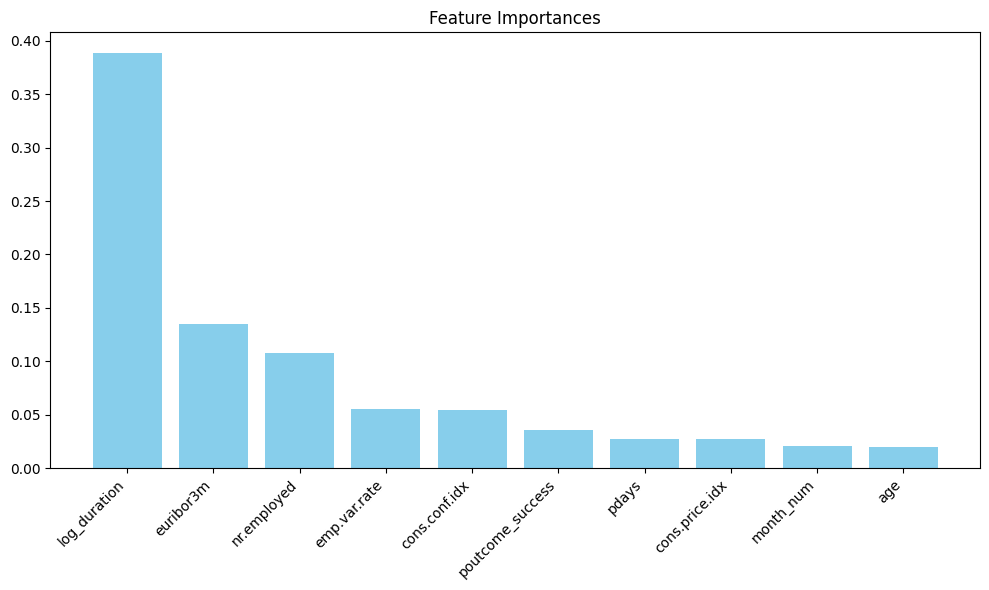

In [114]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tabulate import tabulate
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    max_features='sqrt',
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)

scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='f1')
print("Cross-Validation F1 Scores:", scores)
print("Mean F1 Score:", scores.mean())

rf_model.fit(X_train, y_train)

y_train_pred_rf = rf_model.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred_rf)
training_precision = precision_score(y_train, y_train_pred_rf)
training_recall = recall_score(y_train, y_train_pred_rf)
training_f1 = f1_score(y_train, y_train_pred_rf)

y_test_pred = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)

comparison_results_rf = [
    ["Accuracy", f"{training_accuracy:.4f}", f"{test_accuracy:.4f}"],
    ["Precision", f"{training_precision:.4f}", f"{test_precision:.4f}"],
    ["Recall", f"{training_recall:.4f}", f"{test_recall:.4f}"],
    ["F1-Score", f"{training_f1:.4f}", f"{test_f1:.4f}"],
    ["AUC-ROC", "-", f"{roc_auc_rf:.4f}"]
]

from sklearn.metrics import classification_report

print("Training Performance:")
print(classification_report(y_train, y_train_pred_rf))

print("Test Performance:")
print(classification_report(y_test, y_test_pred))
print(tabulate(comparison_results_rf, headers=["Metric", "Training", "Test"], tablefmt="grid"))

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(indices[:10])), importances[indices[:10]], align="center", color="skyblue")
plt.xticks(range(len(indices[:10])), X.columns[indices[:10]], rotation=45, ha='right')
plt.tight_layout()
plt.show()



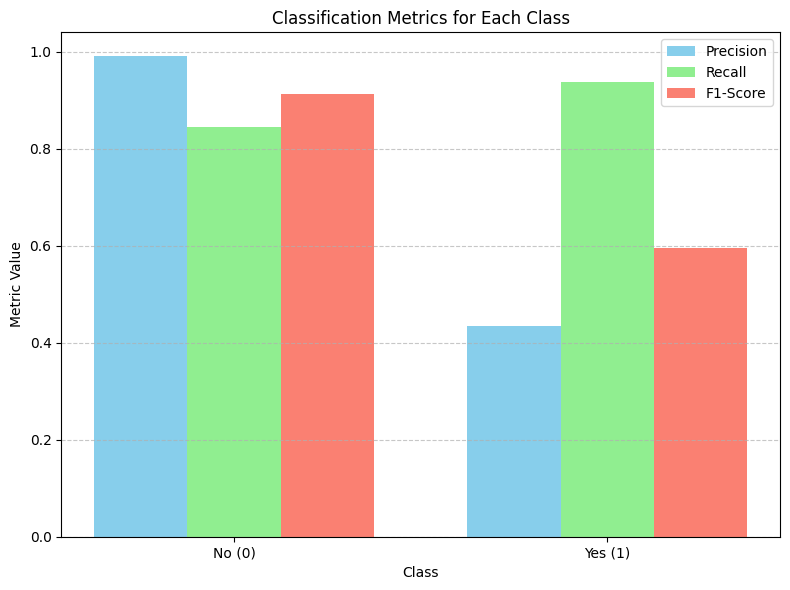

In [115]:
from sklearn.metrics import precision_recall_fscore_support

y_pred_rf = rf_model.predict(X_test)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_rf)

metrics = {
    "Class": ["No (0)", "Yes (1)"],
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1_score
}

x = np.arange(len(metrics["Class"]))
width = 0.25

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(x - width, metrics["Precision"], width, label="Precision", color="skyblue")
ax.bar(x, metrics["Recall"], width, label="Recall", color="lightgreen")
ax.bar(x + width, metrics["F1-Score"], width, label="F1-Score", color="salmon")

ax.set_xlabel("Class")
ax.set_ylabel("Metric Value")
ax.set_title("Classification Metrics for Each Class")
ax.set_xticks(x)
ax.set_xticklabels(metrics["Class"])
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

In [116]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)


In [117]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [118]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
X = pca.fit_transform(X)


In [119]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(clipvalue=1.0)


In [120]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-4)


In [121]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [122]:
print("Total missing values:", np.isnan(X).sum())

Total missing values: 0


In [123]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

X_normalized = scaler.fit_transform(X)

print("Original data:", X)
print("Normalized data (0 to 1):", X_normalized)

print("New feature ranges (min/max):", X_normalized.min(), X_normalized.max())



Original data: [[ 1.86588698e+00  3.01521925e+00 -1.09298733e+00 ... -3.66314419e-01
  -6.69218596e-02  1.02358703e-01]
 [ 1.75513346e+00  1.72289652e+00 -1.78395986e+00 ... -7.28760730e-01
  -5.53057838e-01  2.23933407e-01]
 [ 1.56282865e+00 -5.27648650e-01 -1.83150591e+00 ... -4.08508924e-01
  -3.36206826e-01 -2.70777784e-02]
 ...
 [-1.72623204e+00  3.61224377e+00  1.48583474e+00 ... -1.87549016e+00
   1.23518637e+00  1.31118052e+00]
 [-1.23690448e+00  6.09573413e-01  1.18762780e+00 ... -6.73029223e-01
   1.16008161e+00  7.83069111e-01]
 [-3.89245127e+00  5.27127466e+00  5.87613658e-01 ... -5.05748512e-03
   1.43731213e-01 -1.37157634e+00]]
Normalized data (0 to 1): [[0.85441333 0.5875005  0.37817099 ... 0.44478492 0.25243987 0.66475106]
 [0.84626661 0.48380889 0.29414813 ... 0.40136092 0.22456265 0.67642698]
 [0.83212121 0.30323275 0.28836649 ... 0.43972967 0.23699786 0.65232011]
 ...
 [0.59018711 0.63540373 0.691758   ... 0.26397348 0.32710858 0.78084513]
 [0.62618067 0.39447961 0.

#Neural Network

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
804/804 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8717 - loss: 0.3970 - val_accuracy: 0.8961 - val_loss: 0.2881
Epoch 2/50
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8914 - loss: 0.3090 - val_accuracy: 0.8997 - val_loss: 0.2583
Epoch 3/50
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8983 - loss: 0.2737 - val_accuracy: 0.9016 - val_loss: 0.2406
Epoch 4/50
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8954 - loss: 0.2618 - val_accuracy: 0.9011 - val_loss: 0.2278
Epoch 5/50
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9032 - loss: 0.2414 - val_accuracy: 0.9039 - val_loss: 0.2178
Epoch 6/50
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9016 - loss: 0.2323 - val_accuracy: 0.9050 - val_loss: 0.2105
Epoch 7/50
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9009 - loss: 0.2327 - val_accuracy: 0.9033 - val_loss: 0.2052
Epoch 8/50
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9044 - loss: 0.2198 - val_accuracy: 0.

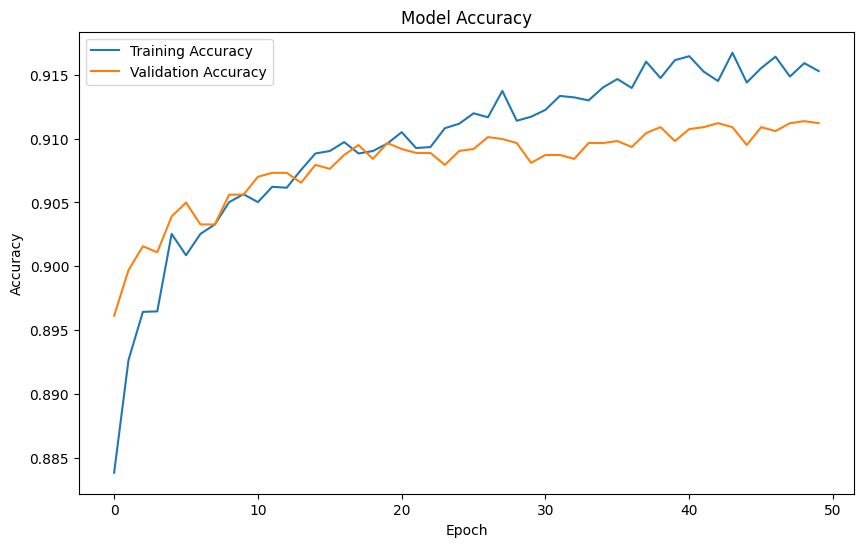

In [124]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from tabulate import tabulate

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

nn_model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

nn_model.compile(
    optimizer=Adam(learning_rate=0.0001, clipvalue=1.0),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = nn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)
nn_train_accuracy = history.history['accuracy'][-1]

y_train_pred_nn = (nn_model.predict(X_train) > 0.5).astype(int)

nn_train_precision = precision_score(y_train, y_train_pred_nn)
nn_train_recall = recall_score(y_train, y_train_pred_nn)
nn_train_f1 = f1_score(y_train, y_train_pred_nn)

imputer = SimpleImputer(strategy='mean')
X_test_imputed = imputer.fit_transform(X_test)

y_test_pred_nn = (nn_model.predict(X_test_imputed) > 0.5).astype(int)
y_proba_nn = nn_model.predict(X_test_imputed).flatten()

nn_test_accuracy = accuracy_score(y_test, y_test_pred_nn)
nn_test_precision = precision_score(y_test, y_test_pred_nn)
nn_test_recall = recall_score(y_test, y_test_pred_nn)
nn_test_f1 = f1_score(y_test, y_test_pred_nn)
nn_roc_auc = roc_auc_score(y_test, y_proba_nn)

comparison_results_nn = [
    ["Accuracy", f"{nn_train_accuracy:.4f}", f"{nn_test_accuracy:.4f}"],
    ["Precision", f"{nn_train_precision:.4f}", f"{nn_test_precision:.4f}"],
    ["Recall", f"{nn_train_recall:.4f}", f"{nn_test_recall:.4f}"],
    ["F1-Score", f"{nn_train_f1:.4f}", f"{nn_test_f1:.4f}"],
    ["AUC-ROC", "-", f"{nn_roc_auc:.4f}"]
]

print("Test Performance:")
print(classification_report(y_test, y_test_pred_nn))
print(tabulate(comparison_results_nn, headers=["Metric", "Training", "Test"], tablefmt="grid"))

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


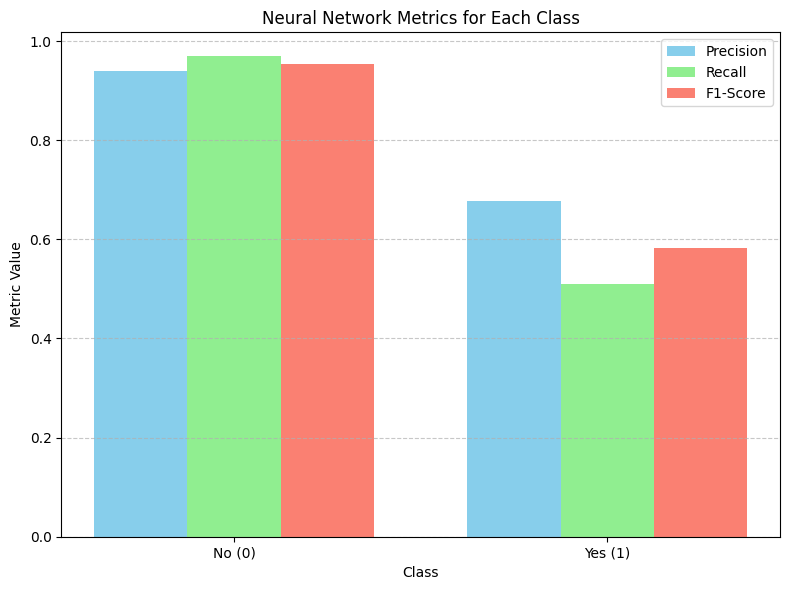

In [125]:
from sklearn.metrics import precision_recall_fscore_support

y_pred_nn = nn_model.predict(X_test)
y_pred_nn = (y_pred_nn > 0.5).astype(int)

precision_nn, recall_nn, f1_score_nn, _ = precision_recall_fscore_support(y_test, y_pred_nn)

metrics_nn = {
    "Class": ["No (0)", "Yes (1)"],
    "Precision": precision_nn,
    "Recall": recall_nn,
    "F1-Score": f1_score_nn
}

x = np.arange(len(metrics_nn["Class"]))
width = 0.25

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(x - width, metrics_nn["Precision"], width, label="Precision", color="skyblue")
ax.bar(x, metrics_nn["Recall"], width, label="Recall", color="lightgreen")
ax.bar(x + width, metrics_nn["F1-Score"], width, label="F1-Score", color="salmon")

ax.set_xlabel("Class")
ax.set_ylabel("Metric Value")
ax.set_title("Neural Network Metrics for Each Class")
ax.set_xticks(x)
ax.set_xticklabels(metrics_nn["Class"])
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()




# Plot ROC curves

 43/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


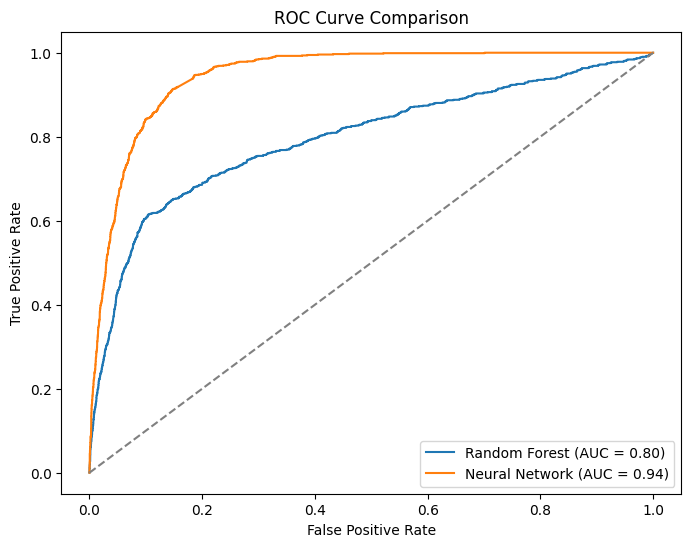

In [126]:
from sklearn.metrics import roc_curve, auc
from sklearn.impute import SimpleImputer


rf_probs = rf_model.predict_proba(X_test)[:, 1]
nn_probs = nn_model.predict(X_test).flatten()

imputer = SimpleImputer(strategy='mean')
nn_probs_imputed = imputer.fit_transform(nn_probs.reshape(-1, 1)).flatten()

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_probs_imputed)

roc_auc_rf = auc(rf_fpr, rf_tpr)
roc_auc_nn = auc(nn_fpr, nn_tpr)

plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.plot(nn_fpr, nn_tpr, label=f"Neural Network (AUC = {roc_auc_nn:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()
